In [2]:
import os  # Operating system interfaces
import joblib
import tensorflow as tf                                    # TensorFlow deep learning framework
import matplotlib.pyplot as plt                            # Plotting library
import matplotlib.image as mpimg                           # Image loading and manipulation library
from tensorflow.keras.models import Sequential, Model      # Sequential and Functional API for building models
from tensorflow.keras.optimizers import Adam               # Adam optimizer for model training
from tensorflow.keras.regularizers import l1, l2           # L1 and L2 regularization for model regularization
from tensorflow.keras.layers import Dense, Flatten,Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,concatenate, Dropout, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import numpy as np
from numpy import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix

import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import albumentations as A
import cv2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers,models

import PIL
import PIL.Image
import tensorflow_datasets as tfds

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
batch_size=32
img_width=224
img_height=224

In [4]:
data_dir="/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset"

In [5]:
import numpy as np
from PIL import Image
import os
from typing import Tuple, Union, List, Dict
from collections import Counter
from pathlib import Path

class BalancedImageAugmentor:
    def __init__(self, target_size: Tuple[int, int] = (224, 224),
                 normalize_mean: Tuple[float, float, float] = (0.485, 0.456, 0.406),
                 normalize_std: Tuple[float, float, float] = (0.229, 0.224, 0.225)):
        self.target_size = target_size
        # self.normalize_mean = normalize_mean
        # self.normalize_std = normalize_std

    def load_image(self, image_path: str) -> Image.Image:
        return Image.open(image_path).convert('RGB')

    def resize_image(self, image: Image.Image) -> Image.Image:
        return image.resize(self.target_size, Image.BILINEAR)

    def horizontal_flip(self, image: Image.Image) -> Image.Image:
        return image.transpose(Image.FLIP_LEFT_RIGHT)

    def normalize(self, image: np.ndarray) -> np.ndarray:
        return image.astype(np.float32) / 255.0

    def denormalize(self, image: np.ndarray) -> np.ndarray:
        """Convert normalized image back to [0, 255] range for display."""
        return (image * 255).astype(np.uint8)
        
    def augment_image(self, image_path: str, augmentation_strength: int = 1) -> List[np.ndarray]:
        augmented_images = []
        image = self.load_image(image_path)
        image = self.resize_image(image)
        
        # Original image
        original_array = np.array(image)
        augmented_images.append(self.normalize(original_array))
        
        # Generate additional augmented versions
        for _ in range(augmentation_strength):
            augmented = self.horizontal_flip(image)
            augmented_array = np.array(augmented)
            augmented_images.append(self.normalize(augmented_array))
        return augmented_images

    def get_image_paths(self, data_dir: str) -> Dict[str, List[Path]]:
        """Get all image paths organized by class."""
        class_paths = {}
        for class_dir in Path(data_dir).iterdir():
            if class_dir.is_dir():
                image_paths = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
                class_paths[class_dir.name] = image_paths
        return class_paths

    def process_class_data(self, paths: List[Path], target_samples: int = None,
                          augment: bool = True) -> List[np.ndarray]:
        """Process images for a single class."""
        processed_images = []
        current_count = len(paths)
        flag=False
        # Add original images first
        for path in paths:
            processed_images.extend(self.augment_image(str(path), 0))
        
        # Add augmented images if needed and augmentation is enabled
        # if augment and target_samples and current_count < target_samples:
            # needed_samples = target_samples - current_count
            # augmentations_per_image = needed_samples // current_count + 1
        if augment:   
            augmentations_per_image=1
            flag=True
            for path in paths:
                # if len(processed_images) >= target_samples and flag:
                #     break
                augmented = self.augment_image(str(path), augmentations_per_image)
                num_images = len(augmented)
                # plt.figure(figsize=(15, 5))
                
                # for i, img in enumerate(augmented):
                #     # Denormalize the image for display
                #     img_display = self.denormalize(img)
                    
                #     # Plot the image
                #     plt.subplot(1, num_images, i + 1)
                #     plt.imshow(img_display)
                #     plt.title(f"Image {i + 1}")
                #     plt.axis('off')
                
                # plt.tight_layout()
                # plt.show()
                
                processed_images.extend(augmented[1:])
            
            # Trim to target size
            # processed_images = processed_images[:target_samples]
            
        return processed_images

    def get_class_distribution(self, data_dir: str) -> Dict[str, int]:
        class_paths = self.get_image_paths(data_dir)
        return {class_name: len(paths) for class_name, paths in class_paths.items()}

    def balance_dataset(self, class_paths: str, target_samples_per_class: int = None,
                       min_multiplier: float = 1.0) -> Dict[str, List[np.ndarray]]:
        # Get all image paths
        # class_paths = self.get_image_paths(data_dir)
        
        # Determine target size
        class_counts = {name: len(paths) for name, paths in class_paths.items()}
        # max_class_size = max(class_counts.values())
        
        # if target_samples_per_class is None:
        #     target_samples_per_class = max_class_size
        
        # target_samples_per_class = max(target_samples_per_class, 
        #                              int(max_class_size * min_multiplier))

        # Process each class
        balanced_dataset = {}
        # for class_name, paths in class_paths.items():
        #     balanced_dataset[class_name] = self.process_class_data(
        #         paths, target_samples_per_class, augment=True
        #     )
        for class_name, paths in class_paths.items():
            balanced_dataset[class_name] = self.process_class_data(
                paths, augment=True
            )
        
        return balanced_dataset
    def split_and_balance_dataset(self, data_dir: str, validation_split: float = 0.2, 
                                target_samples_per_class: int = None,
                                min_multiplier: float = 1.0,
                                random_seed: int = 42):
        np.random.seed(random_seed)
        
        # Split data into train and validation paths
        train_paths = {}
        val_paths = {}
        
        for class_dir in Path(data_dir).iterdir():
            if class_dir.is_dir():
                image_paths = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
                
                # Shuffle and split
                np.random.shuffle(image_paths)
                split_idx = int(len(image_paths) * (1 - validation_split))
                
                train_paths[class_dir.name] = image_paths[:split_idx]
                val_paths[class_dir.name] = image_paths[split_idx:]
    
        # Use existing balance_dataset for training data
        balanced_train = self.balance_dataset(train_paths, target_samples_per_class, min_multiplier)
    
        # Prepare validation data (no augmentation)
        validation_data = {}
        for class_name, paths in val_paths.items():
            validation_data[class_name] = []
            for path in paths:
                validation_data[class_name].extend(self.augment_image(str(path), 0))
    
        return balanced_train, validation_data

In [6]:
# Initialize the augmentor
augmentor = BalancedImageAugmentor(
    target_size=(224, 224)
)

# Check initial distribution
initial_dist = augmentor.get_class_distribution(data_dir)
initial_dist = sorted(initial_dist)
print("Initial distribution:", initial_dist)

# Split and balance the dataset
train_data, val_data = augmentor.split_and_balance_dataset(
    data_dir=data_dir,
    validation_split=0.2,  # 20% for validation
    random_seed=42  # For reproducibility
)

# class_names=[]
# Print the final distribution
print("\nFinal distribution:")
sorted_class_names = sorted(train_data.keys())
for class_name in sorted_class_names:
    # class_names.append(class_name)
    print(f"{class_name}:")
    print(f"  Training samples: {len(train_data[class_name])}")
    print(f"  Validation samples: {len(val_data[class_name])}")


Initial distribution: ['F0', 'F1', 'F2', 'F3', 'F4']

Final distribution:
F0:
  Training samples: 3382
  Validation samples: 423
F1:
  Training samples: 1376
  Validation samples: 173
F2:
  Training samples: 1268
  Validation samples: 159
F3:
  Training samples: 1370
  Validation samples: 172
F4:
  Training samples: 2716
  Validation samples: 340


In [7]:
class_names=[]
for class_name in sorted_class_names:
    class_names.append(class_name)

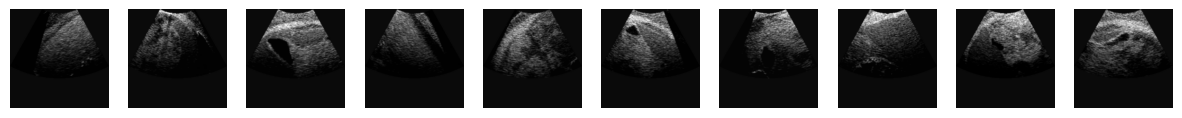

In [8]:
def show_images(images: List[np.ndarray]):
    """Display a list of images."""
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

# Display a sample of augmented images from one class
sample_class_name = list(sorted_class_names)[2]  # Take the second class
sample_images = train_data[sample_class_name][10:20]  # Display first 5 augmented images

# Show the images
show_images(sample_images)

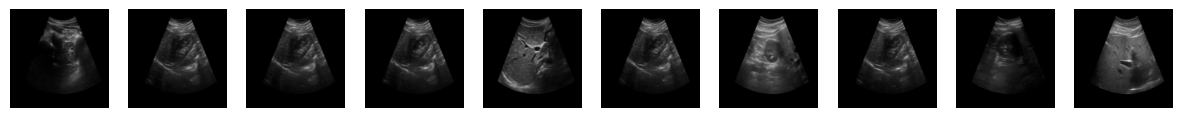

In [9]:
# Display a sample of augmented images from one class
sample_class_name = list(sorted(val_data.keys()))[0]  # Take the first class
sample_images = val_data[sample_class_name][:10]  # Display first 5 augmented images

# Show the images
show_images(sample_images)

In [10]:
class_names

['F0', 'F1', 'F2', 'F3', 'F4']

In [10]:
# The data is now ready to use with your model
# train_data[class_name] contains normalized image arrays for training
# val_data[class_name] contains normalized image arrays for validation

In [11]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

# # Convert train_data and val_data into Keras-compatible format
# def prepare_data(data: Dict[str, List[np.ndarray]]) -> Tuple[np.ndarray, np.ndarray]:
#     x = []
#     y = []
#     # class_names = list(data.keys())
    
#     for class_idx, class_name in enumerate(class_names):
#         images = data[class_name]
#         x.extend(images)  # Add images
#         y.extend([class_idx] * len(images))  # Add class labels
    
#     # Convert to NumPy arrays
#     x = np.array(x)
#     y = to_categorical(y, num_classes=len(class_names))  # One-hot encode labels
    
#     return x, y

# # Prepare training and validation data
# x_train, y_train = prepare_data(train_data)
# x_val, y_val = prepare_data(val_data)

import numpy as np
from keras.utils import to_categorical
from typing import Dict, List, Tuple

def prepare_data(data: Dict[str, List[np.ndarray]], 
                class_order: List[str] = ['F0', 'F1', 'F2', 'F3', 'F4']) -> Tuple[np.ndarray, np.ndarray]:
    """
    Prepare data for Keras model training
    
    Args:
        data: Dictionary with class names as keys and lists of images as values
        class_order: Definitive order of classes for consistent labeling
        
    Returns:
        Tuple of (images, one-hot encoded labels)
    """
    x = []
    y = []
    
    # Validate all images first
    for class_name, images in data.items():
        if class_name not in class_order:
            raise ValueError(f"Class {class_name} not in predefined class order")
            
        for img in images:
            if img.shape != (224, 224, 3):  # Assuming your target size
                raise ValueError(f"Image shape {img.shape} doesn't match expected (224, 224, 3)")
                
            if img.max() > 1.0 or img.min() < 0.0:  # Check normalization
                raise ValueError("Image values should be normalized to [0,1] range")
    
    # Prepare data with consistent ordering
    for class_idx, class_name in enumerate(class_order):
        if class_name in data:
            images = data[class_name]
            x.extend(images)
            y.extend([class_idx] * len(images))
    
    # Convert to NumPy arrays
    x_array = np.array(x)
    y_array = to_categorical(y, num_classes=len(class_order))
    
    # Verify we didn't lose any samples
    if len(x_array) != len(y_array):
        raise ValueError("Mismatch between number of samples and labels")
    
    return x_array, y_array

# Usage example:
CLASS_ORDER = ['F0', 'F1', 'F2', 'F3', 'F4']  # Define this globally

# Prepare training and validation data
x_train, y_train = prepare_data(train_data, class_order=CLASS_ORDER)
x_val, y_val = prepare_data(val_data, class_order=CLASS_ORDER)

# Verify shapes
print(f"Training data shape: {x_train.shape}, labels shape: {y_train.shape}")
print(f"Validation data shape: {x_val.shape}, labels shape: {y_val.shape}")

# Verify class distribution
print("\nClass distribution in training:")
print(np.sum(y_train, axis=0))  # Should show counts per class

Training data shape: (10112, 224, 224, 3), labels shape: (10112, 5)
Validation data shape: (1267, 224, 224, 3), labels shape: (1267, 5)

Class distribution in training:
[3382. 1376. 1268. 1370. 2716.]


In [12]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

# Step 1: Load a pre-trained model
from tensorflow.keras.applications import MobileNet

# Load MobileNet instead of ResNet50
base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# Freeze the base model layers (optional, for feature extraction)
for layer in base_model.layers:
    layer.trainable = False

# Step 3: Modify the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation="relu")(x)  # Fully connected layer
predictions = Dense(len(train_data.keys()), activation="softmax")(x)  # Output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

# Step 4: Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=16,
    epochs=10
)

# Step 5: Evaluate the model
results = model.evaluate(x_val, y_val, verbose=1)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,283,589 (16.34 MB)

 Trainable params: 1,054,725 (4.02 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6286 - loss: 1.0019 - val_accuracy: 0.7388 - val_loss: 0.5744
Epoch 2/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8422 - loss: 0.3930 - val_accuracy: 0.8729 - val_loss: 0.3080
Epoch 3/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8961 - loss: 0.2656 - val_accuracy: 0.8958 - val_loss: 0.2492
Epoch 4/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9328 - loss: 0.1789 - val_accuracy: 0.8761 - val_loss: 0.2937
Epoch 5/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9412 - loss: 0.1630 - val_accuracy: 0.8919 - val_loss: 0.3169
Epoch 6/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9661 - loss: 0.0984 - val_accuracy: 0.9526 - val_loss: 0.1375
Epoch 7/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9775 - loss: 0.0688 - val_accuracy: 0.9526 - val_loss: 0.1250
Epoch 8/10
632/632 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9838 - loss: 0.0555 - val_acc

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load ResNet50 with pre-trained ImageNet weights
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (for feature extraction)
for layer in base_model.layers:
    layer.trainable = False

# Modify the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = BatchNormalization()(x)  # Batch normalization
x = Dense(1024, activation="relu")(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(len(train_data.keys()), activation="softmax")(x)  # Output layer

# Create the final model
ResNet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with an adaptive learning rate scheduler
ResNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
ResNet.summary()

# Callbacks for learning rate reduction and early stopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Train the model
history = ResNet.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

# Evaluate the model
results = ResNet.evaluate(x_val, y_val, verbose=1)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,699,205 (98.03 MB)

 Trainable params: 2,107,397 (8.04 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.5951 - loss: 0.9934 - val_accuracy: 0.3867 - val_loss: 1.2022 - learning_rate: 0.0010
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.7192 - loss: 0.6876 - val_accuracy: 0.7056 - val_loss: 0.6619 - learning_rate: 0.0010
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.7574 - loss: 0.5946 - val_accuracy: 0.8011 - val_loss: 0.4858 - learning_rate: 0.0010
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.7993 - loss: 0.5056 - val_accuracy: 0.8469 - val_loss: 0.4046 - learning_rate: 0.0010
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.8238 - loss: 0.4439 - val_accuracy: 0.8485 - val_loss: 0.3848 - learning_rate: 0.0010
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.8473 - loss: 0.4018 - val_accuracy: 0.8824 - val_loss: 0.3401 - learning_rate: 0.0010
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.8611 - l

In [15]:
from tensorflow.keras.applications import VGG16

# Load VGG16 without the top layer
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 4 layers for fine-tuning
for layer in base_model.layers[:-4]:  
    layer.trainable = False
for layer in base_model.layers[-4:]:  
    layer.trainable = True

# Build custom head for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_data.keys()), activation="softmax")(x)  # Adjust output for class count

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True
)
train_generator = train_datagen.flow(x_train, y_train, batch_size=16)

# Callbacks for training
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=(x_val, y_val),
    batch_size=16,
    epochs=20,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

# Evaluate the model
results = model.evaluate(x_val, y_val, verbose=1)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")
# Save the model
model.save("vgg16_liver_cirrhosis_model.h5")
print("Model saved as vgg_16_liver_cirrhosis_model.h5")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 15,249,221 (58.17 MB)

 Trainable params: 7,611,909 (29.04 MB)

 Non-trainable params: 7,637,312 (29.13 MB)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


632/632 ━━━━━━━━━━━━━━━━━━━━ 107s 155ms/step - accuracy: 0.5527 - loss: 1.1387 - val_accuracy: 0.6938 - val_loss: 0.7718 - learning_rate: 1.0000e-04
Epoch 2/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 95s 149ms/step - accuracy: 0.7052 - loss: 0.7172 - val_accuracy: 0.7159 - val_loss: 0.9729 - learning_rate: 1.0000e-04
Epoch 3/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 95s 149ms/step - accuracy: 0.7800 - loss: 0.5557 - val_accuracy: 0.8571 - val_loss: 0.3793 - learning_rate: 1.0000e-04
Epoch 4/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 95s 149ms/step - accuracy: 0.8418 - loss: 0.4159 - val_accuracy: 0.8390 - val_loss: 0.4165 - learning_rate: 1.0000e-04
Epoch 5/20
631/632 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8652 - loss: 0.3615
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
632/632 ━━━━━━━━━━━━━━━━━━━━ 95s 149ms/step - accuracy: 0.8652 - loss: 0.3614 - val_accuracy: 0.8224 - val_loss: 0.4903 - learning_rate: 1.0000e-04
Epoch 6/20
632/632 ━━━━━━━━━━━━━━━━━━━━ 95s 148ms/step - accur

In [16]:
from tensorflow.keras.applications import VGG19


base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers[:-4]:  
    layer.trainable = False
for layer in base_model.layers[-4:]:  
    layer.trainable = True


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_data.keys()), activation="softmax")(x)  # عدد الفئات


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


model.summary()

train_datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True
)
train_generator = train_datagen.flow(x_train, y_train, batch_size=16)


checkpoint = ModelCheckpoint("vgg19_best_model.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)


history = model.fit(
    train_generator,
    validation_data=(x_val, y_val),
    batch_size=16,
    epochs=30,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)


results = model.evaluate(x_val, y_val, verbose=1)
print(f"🔹 Validation Loss: {results[0]:.4f}")
print(f"🔹 Validation Accuracy: {results[1]:.4f}")
# Save the model
model.save("vgg_19_liver_cirrhosis_model.h5")
print("Model saved as vgg19_liver_cirrhosis_model.h5")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,558,917 (78.43 MB)

 Trainable params: 7,611,909 (29.04 MB)

 Non-trainable params: 12,947,008 (49.39 MB)

Epoch 1/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 104s 157ms/step - accuracy: 0.5309 - loss: 1.2052 - val_accuracy: 0.5556 - val_loss: 1.1062 - learning_rate: 1.0000e-04
Epoch 2/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 96s 150ms/step - accuracy: 0.6426 - loss: 0.8748 - val_accuracy: 0.6969 - val_loss: 0.7545 - learning_rate: 1.0000e-04
Epoch 3/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 96s 150ms/step - accuracy: 0.7076 - loss: 0.7110 - val_accuracy: 0.7222 - val_loss: 0.6996 - learning_rate: 1.0000e-04
Epoch 4/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 96s 150ms/step - accuracy: 0.7597 - loss: 0.6098 - val_accuracy: 0.7830 - val_loss: 0.8300 - learning_rate: 1.0000e-04
Epoch 5/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 95s 149ms/step - accuracy: 0.7879 - loss: 0.5254 - val_accuracy: 0.7301 - val_loss: 1.0173 - learning_rate: 1.0000e-04
Epoch 6/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 96s 150ms/step - accuracy: 0.8212 - loss: 0.4675 - val_accuracy: 0.8421 - val_loss: 0.4334 - learning_rate: 1.0000e-04
Epoch 7/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 98s 1

In [13]:
from keras import layers
from keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

img_size = (224, 224, 3)

NNM_model = NASNetMobile(
    include_top=False,
    weights="imagenet",
    input_shape=img_size
)

x = NNM_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)


predictions = Dense(5, activation="softmax", kernel_regularizer=l2(0.0005))(x)


for layer in NNM_model.layers[:-25]:
    layer.trainable = False

modeNNM = Model(inputs=NNM_model.input, outputs=predictions)

modeNNM.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = modeNNM.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=16,
    epochs=30,
    callbacks=[early_stopping]
)

# Evaluate the model
results = modeNNM.evaluate(x_val, y_val, verbose=1)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")

# Save the model
modeNNM.save("modelNNM.h5")
print("Model saved as modelNNM.h5")

Epoch 1/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 77s 71ms/step - accuracy: 0.4412 - loss: 1.6738 - val_accuracy: 0.6038 - val_loss: 1.1965
Epoch 2/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.5950 - loss: 1.0963 - val_accuracy: 0.6717 - val_loss: 1.0253
Epoch 3/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.6621 - loss: 0.9137 - val_accuracy: 0.7088 - val_loss: 0.7823
Epoch 4/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7039 - loss: 0.7593 - val_accuracy: 0.7340 - val_loss: 0.7658
Epoch 5/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.7393 - loss: 0.6791 - val_accuracy: 0.7356 - val_loss: 0.7957
Epoch 6/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7618 - loss: 0.6094 - val_accuracy: 0.7490 - val_loss: 0.7566
Epoch 7/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7987 - loss: 0.5304 - val_accuracy: 0.7845 - val_loss: 0.6136
Epoch 8/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.8243 - loss: 0.4579 - 

In [14]:
from keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

img_size = (224, 224, 3)

Dense2_model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=img_size
)

for layer in Dense2_model.layers[:-20]:
    layer.trainable = False

x = Dense2_model.layers[-4].output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.0005))(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation="softmax")(x)


Dense_model = Model(inputs=Dense2_model.input, outputs=predictions)


Dense_model.compile(
    Adam(learning_rate=0.00005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

history = Dense_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=8,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate Model
results = Dense_model.evaluate(x_val, y_val, verbose=1)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")

# Save Model
Dense_model.save("Dense_model.h5")
print("Optimized model saved as Dense_model.h5")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 73s 37ms/step - accuracy: 0.4121 - loss: 1.3695 - val_accuracy: 0.6827 - val_loss: 0.7738 - learning_rate: 5.0000e-05
Epoch 2/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6488 - loss: 0.8734 - val_accuracy: 0.7727 - val_loss: 0.5565 - learning_rate: 5.0000e-05
Epoch 3/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.7377 - loss: 0.6715 - val_accuracy: 0.8161 - val_loss: 0.4568 - learning_rate: 5.0000e-05
Epoch 4/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.7802 - loss: 0.5746 - val_accuracy: 0.8524 - val_loss: 0.3775 - learning_rate: 5.0000e-05
Epoch 5/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8137 - loss: 0.4949 - val_accuracy: 0.8816 - val_loss: 0.3295 - learning_rate: 5.0000e-05
Epoch 6/30
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8385 - loss: 0.4230 - val_accuracy: 0.9045 - val_loss: 0.2694 - learning_rate: 

In [15]:
from keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 

img_size = (224, 224, 3)

IRNV2 = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=img_size
    )

x = IRNV2.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = BatchNormalization()(x) 
x = Dropout(0.5)(x)

predictions = Dense(5, activation="softmax")(x)


for layer in IRNV2.layers[:-12]:
    layer.trainable = False

modelIRNV2 = Model(inputs=IRNV2.input, outputs=predictions)

modelIRNV2.compile(
    Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
    )

history = modelIRNV2.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=16,
    epochs=15
    )

# Evaluate the model
results = modelIRNV2.evaluate(x_val, y_val, verbose=1)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")

# Save the model
modelIRNV2.save("InceptionResNetV2.h5")
print("Model saved as InceptionResNetV2.h5")

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 85s 92ms/step - accuracy: 0.6053 - loss: 1.2818 - val_accuracy: 0.8145 - val_loss: 0.4942
Epoch 2/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.8541 - loss: 0.4022 - val_accuracy: 0.9021 - val_loss: 0.2632
Epoch 3/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.9246 - loss: 0.2093 - val_accuracy: 0.9290 - val_loss: 0.2364
Epoch 4/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.9513 - loss: 0.1387 - val_accuracy: 0.9542 - val_loss: 0.1650
Epoch 5/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.9658 - loss: 0.0879 - val_accuracy: 0.9590 - val_loss: 0.1596
Epoch 6/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.9717 - loss: 0.0895 - val_accuracy: 0.9803 - val_loss: 0.0882
Epoch 7/15
632/632 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.9770 - loss: 0.0713 - val_accuracy: 0.9763 - val_loss: 0.1224
Epoch 8/15
632/632 ━━━━━━━━━━━━━━━━━━

In [16]:
# Function to load trained model
def load_trained_model(model_path):
    return tf.keras.models.load_model(model_path)

# Function to preprocess uploaded ultrasound image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize
    return img_array

# Function to predict fibrosis stage
def predict_fibrosis(model, image_path, class_labels):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_label = class_labels[predicted_class]
    fibrosis_status = "Yes Fibrosis" if predicted_label != "F0" else "No Fibrosis"
    return fibrosis_status, predicted_label


class_labels = ['F0', 'F1', 'F2', 'F3', 'F4']



In [17]:
# Load the trained model
model = load_trained_model("/kaggle/working/Dense_model.h5")

# List of test images from different fibrosis stages
test_images = [
    ("/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F0/a1027.jpg", "F0"),
    ("/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F1/A9777.jpg", "F1"),
    ("/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F2/I3935.jpg", "F2"),
    ("/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F3/J3166.jpg", "F3"),
    ("/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset/F4/F5642.jpg", "F4")
]

for image_path, actual_stage in test_images:
    fibrosis_status, predicted_stage = predict_fibrosis(model, image_path, class_labels)
    print(f"Actual Stage: {actual_stage}, Predicted Stage: {predicted_stage}, Fibrosis Status: {fibrosis_status}")

  

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Actual Stage: F0, Predicted Stage: F0, Fibrosis Status: No Fibrosis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Actual Stage: F1, Predicted Stage: F1, Fibrosis Status: Yes Fibrosis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Actual Stage: F2, Predicted Stage: F2, Fibrosis Status: Yes Fibrosis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Actual Stage: F3, Predicted Stage: F3, Fibrosis Status: Yes Fibrosis
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Actual Stage: F4, Predicted Stage: F4, Fibrosis Status: Yes Fibrosis


In [ ]:
# # Define the model
# model = Sequential()

# # Block 1
# model.add(Conv2D(input_shape=(224, 224, 3), filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# # Block 2
# model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# # Block 3
# model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# # Block 4
# model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# # Block 5
# model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# # Fully Connected Layers
# model.add(Flatten())
# model.add(Dense(units=4096, activation="relu"))
# model.add(Dense(units=4096, activation="relu"))
# model.add(Dense(units=len(train_data.keys()), activation="softmax"))  # Number of classes

# # Compile the model
# opt = Adam(learning_rate=0.001)
# model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])

# # Print model summary
# model.summary()

# # # Define callbacks
# # checkpoint = ModelCheckpoint("model_best.h5", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
# # early = EarlyStopping(monitor="val_accuracy", patience=10, mode="max", verbose=1)

# # Train the model
# hist = model.fit(
#     x_train, y_train,
#     validation_data=(x_val, y_val),
#     batch_size=32,
#     epochs=100,
#     # callbacks=[checkpoint, early]
# )

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# # Load ResNet50 with pre-trained ImageNet weights
# base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# # Freeze the base model layers (for feature extraction)
# for layer in base_model.layers:
#     layer.trainable = False

# # Modify the pre-trained model
# x = base_model.output
# x = GlobalAveragePooling2D()(x)  # Global average pooling
# x = BatchNormalization()(x)  # Batch normalization
# x = Dense(1024, activation="relu")(x)  # Fully connected layer
# x = Dropout(0.5)(x)  # Dropout for regularization
# predictions = Dense(len(train_data.keys()), activation="softmax")(x)  # Output layer

# # Create the final model
# ResNet = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model with an adaptive learning rate scheduler
# ResNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                loss="categorical_crossentropy", metrics=["accuracy"])

# # Print model summary
# ResNet.summary()

# # Data augmentation for better generalization
# datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     zoom_range=0.2,
#     fill_mode='nearest'
# )

# datagen.fit(x_train)

# # Callbacks for learning rate reduction and early stopping
# callbacks = [
#     ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6),
#     EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# ]

# # Train the model
# history = ResNet.fit(
#     datagen.flow(x_train, y_train, batch_size=32),
#     validation_data=(x_val, y_val),
#     epochs=30,
#     callbacks=callbacks,
#     verbose=1
# )

# # Evaluate the model
# results = ResNet.evaluate(x_val, y_val, verbose=1)
# print(f"Validation Loss: {results[0]:.4f}")
# print(f"Validation Accuracy: {results[1]:.4f}")
